<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Why and What If? Causal Inference For Everyone</h1>
        <h1>Approaches</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

from scipy import stats
from sklearn.linear_model import LinearRegression

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 0c7e76716661fcb24525a9c7416893a7947894d7

numpy     : 1.19.2
scipy     : 1.6.1
watermark : 2.1.0
matplotlib: 3.3.2
pandas    : 1.1.3
networkx  : 2.5
json      : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Probability Review

In [4]:
data = pd.read_csv('data/Berkeley.csv')

In [5]:
data

,Department,Gender,Accepted,Rejected
0,A,Men,512,313
1,A,Women,89,19
2,B,Men,353,207
3,B,Women,17,8
4,C,Men,120,205
5,C,Women,202,392
6,D,Men,138,279
7,D,Women,131,244
8,E,Men,53,138
9,E,Women,94,299


Marginals

In [6]:
N_gender = data[['Gender', 'Accepted', 'Rejected']].groupby(['Gender']).sum()

In [7]:
N_gender

,Accepted,Rejected
Gender,,
Men,1192,1398
Women,557,1279


Gender distribution

In [8]:
P_gender = N_gender.sum(axis=1)/N_gender.sum(axis=1).sum()

In [9]:
P_gender

Gender
Men      0.585178
Women    0.414822
dtype: float64

Conditional Probability of being accepted given gender

In [10]:
P_acceptance_gender = N_gender.apply(lambda x:x/x.sum(), axis=1)

In [11]:
P_acceptance_gender

,Accepted,Rejected
Gender,,
Men,0.460232,0.539768
Women,0.303377,0.696623


Conditional Probability of being accepted given department

In [12]:
P_acceptance_department = data.groupby(['Department']).sum()
P_acceptance_department = P_acceptance_department.apply(lambda x:x/x.sum(), axis=1)

In [13]:
P_acceptance_department.round(2)

,Accepted,Rejected
Department,,
A,0.64,0.36
B,0.63,0.37
C,0.35,0.65
D,0.34,0.66
E,0.25,0.75
F,0.07,0.93


Conditional Probability of being accepted by gender and department

In [14]:
P_acceptance_gender_department = data.copy()
P_acceptance_gender_department[['Accepted', 'Rejected']] = P_acceptance_gender_department[['Accepted', 'Rejected']].apply(lambda x:x/data.sum(axis=1))

In [15]:
P_acceptance_gender_department

,Department,Gender,Accepted,Rejected
0,A,Men,0.620606,0.379394
1,A,Women,0.824074,0.175926
2,B,Men,0.630357,0.369643
3,B,Women,0.680000,0.320000
4,C,Men,0.369231,0.630769
5,C,Women,0.340067,0.659933
6,D,Men,0.330935,0.669065
7,D,Women,0.349333,0.650667
8,E,Men,0.277487,0.722513
9,E,Women,0.239186,0.760814


Text(0, 0.5, '$P\\left(accepted\\right)$')

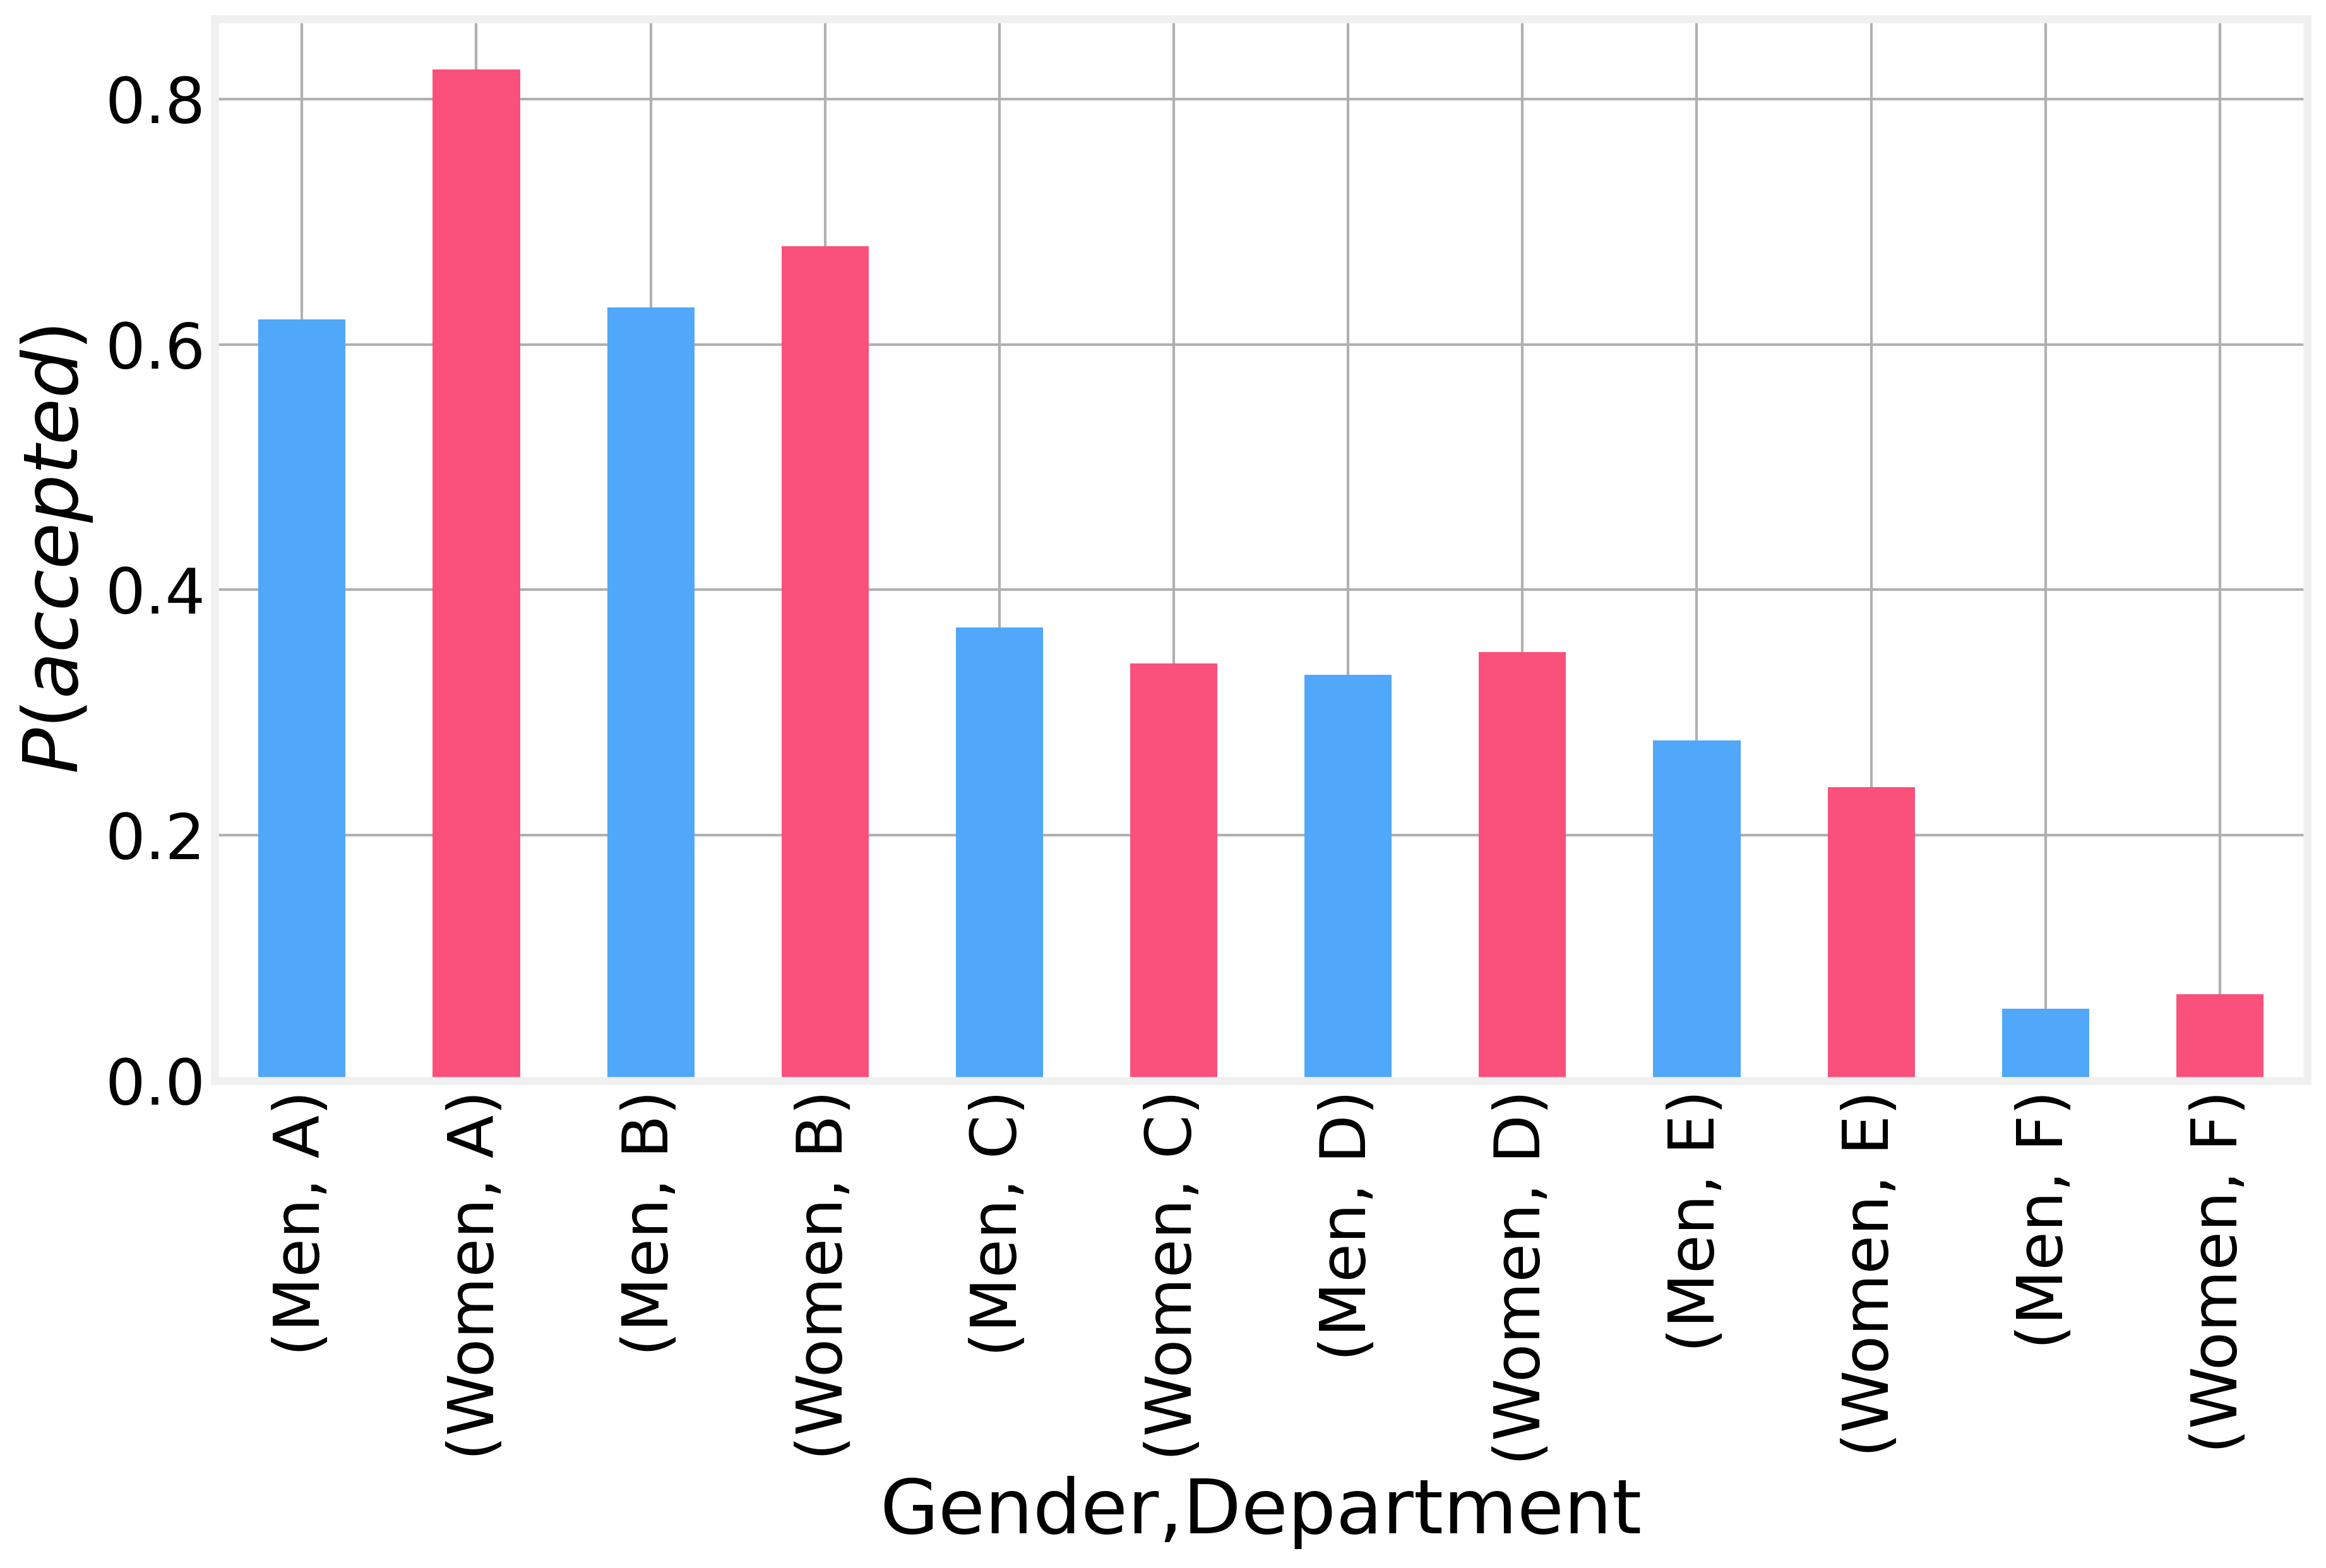

In [16]:
ax = P_acceptance_gender_department.set_index(['Gender', 'Department'])['Accepted'].plot.bar(color=[colors[0], colors[5]])
ax.set_ylabel(r'$P\left(accepted\right)$')

## Hypothesis Testing

### Simulated data

In [17]:
def get_data(N, pA, pB, fraction=0.5):
    df = pd.DataFrame({'group': (np.random.random(N)<(1-fraction)).astype('int'), 'conversion': 0})
    counts = df.groupby('group').count()
    
    NA = counts.loc[0, 'conversion']
    NB = counts.loc[1, 'conversion']
    
    df.loc[df['group']==0, 'conversion'] = (np.random.random(NA) < pA).astype('int')
    df.loc[df['group']==1, 'conversion'] = (np.random.random(NB) < pB).astype('int')    

    return df

Let's generate some random data. We're assuming two groups of users (chosen at random with probability $1/2$). The first group (control) has a conversion probability $p_A=5\%$ and the new group has a conversion probability $p_B=7.5\%$

In [18]:
pA_theory = 0.05
pB_theory = 0.075
N = 2000
data = get_data(N, pA_theory, pB_theory)

In [19]:
data

,group,conversion
0,0,0
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
1995,0,0
1996,0,0
1997,0,0
1998,1,0


### Group averages

conversion=1 means that they bought our product, while conversion=0 means they didn't. We can cheack how many users we have in each group

In [20]:
counts = data.groupby('group').count()
counts

,conversion
group,
0,984
1,1016


And the fraction that converted within each group

In [21]:
means = data.groupby('group').mean()
(means*100).round(2)

,conversion
group,
0,5.18
1,8.37


The conversion fractions are different from the theoretical ones. We can assume that each conversion is an independent process (similar to a coin flip), in which case, we expect that the observed values follow a Binomial distribution.

### Hypothesis Testing

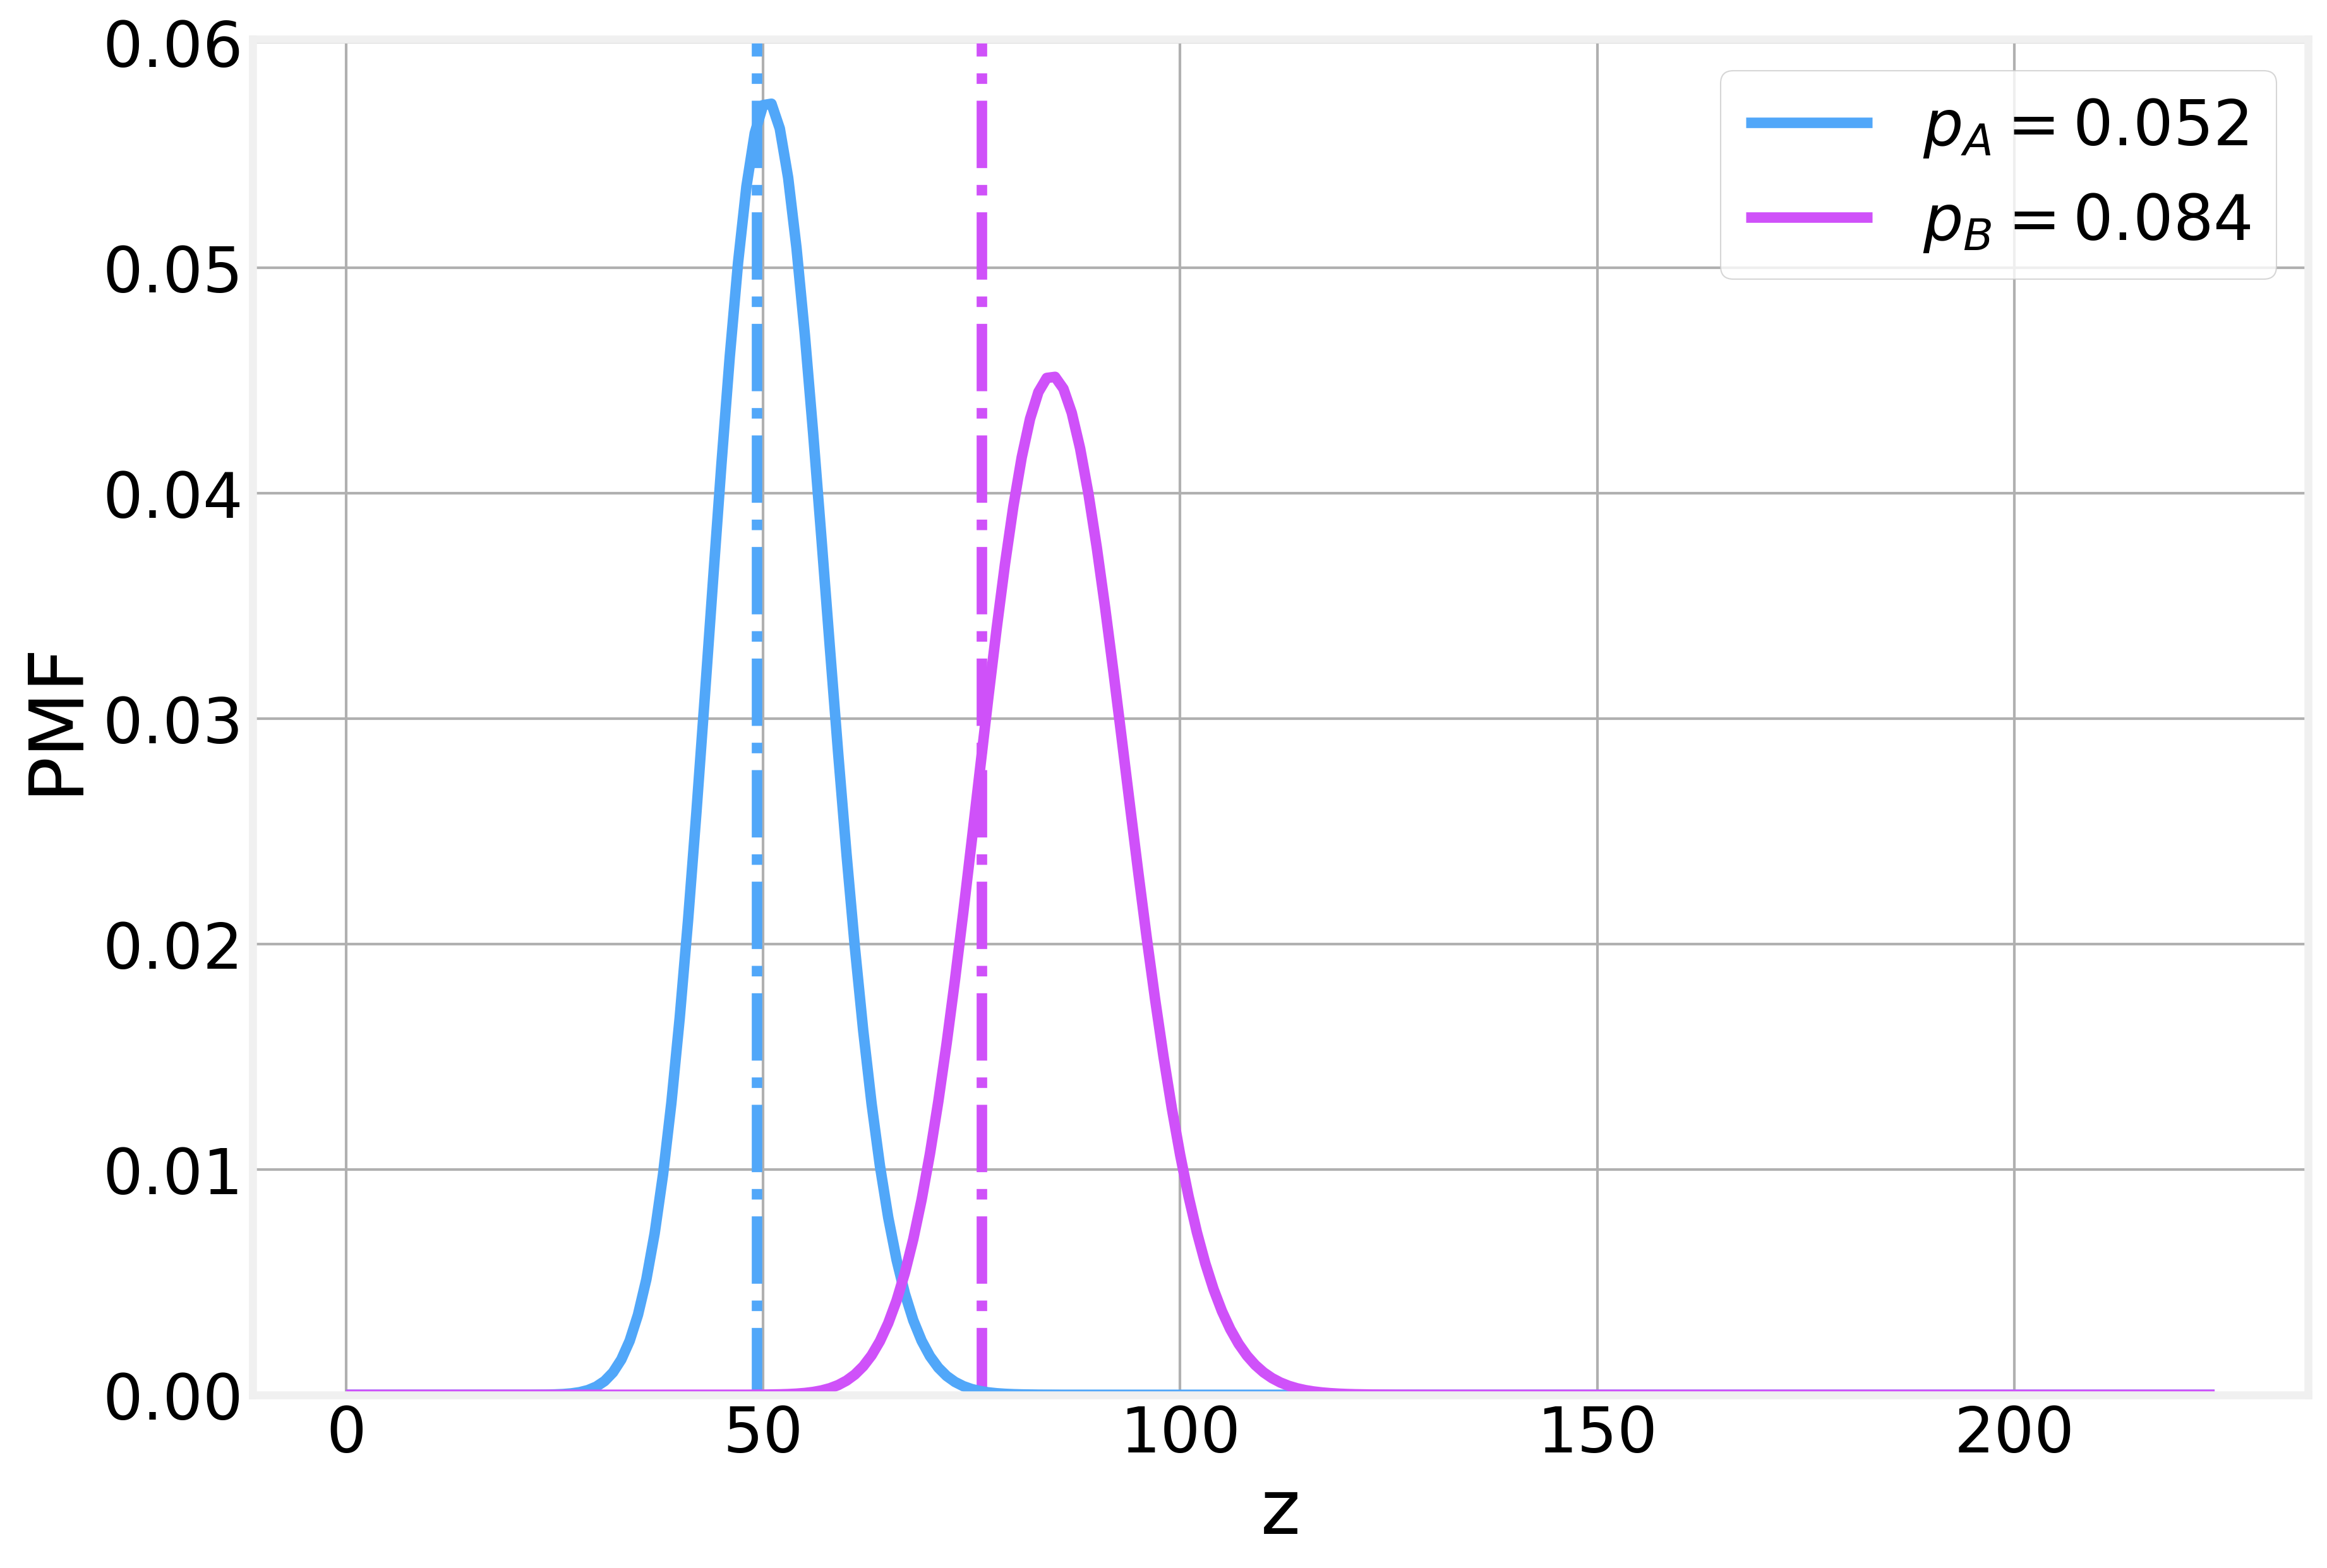

In [22]:
fig, ax = plt.subplots(1, 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.set_xlabel('z')
ax.set_ylabel('PMF')

x = np.arange(0, N*pB_theory*1.5)
yA = stats.binom(n=counts.iloc[0, 0], p=means.iloc[0, 0]).pmf(x)
ax.plot(x, yA, label=r'$p_A=%1.3f$' % means.iloc[0])

yB = stats.binom(n=counts.iloc[1, 0], p=means.iloc[1, 0]).pmf(x)
ax.plot(x, yB, label=r'$p_B=%1.3f$' % means.iloc[1])

height = np.max([yA.max(), yB.max()])*1.05

ax.vlines(x=[pA_theory*counts.iloc[0], pB_theory*counts.iloc[1]], ymin=0, ymax=height, colors=colors[:2], linestyles='-.')
ax.set_ylim(0, height)
plt.legend()

This figure clearly illustrates that the observed number of conversions can be significantly differnet from the one we might expect theoretically (as represented by the dashed lines). Indeed, we can take the observed value as an "experimental measurement" of the true value. 

From the central limit theorem, we know that the difference between the true and the experimental values follows a gaussian distribution centered at zero and with a standard deviation given by the standard error of the meaurement. For a Bernoulli process, the standard error is given by

$$SE=\sqrt{\frac{p\left(1-p\right)}{N}}$$

In [23]:
pA = means.iloc[0]
NA = counts.iloc[0]
SEA = np.sqrt(pA*(1-pA)/NA)

pB = means.iloc[1]
NB = counts.iloc[1]
SEB = np.sqrt(pB*(1-pB)/NB)

The corresponding Z score is then given by:

$$Z=\frac{p_B-p_A}{\sqrt{SE_A^2+SE_B^2}}$$

In [24]:
def zscore(pA, pB, NA, NB):
    SEA = np.sqrt(pA*(1-pA)/NA)
    SEB = np.sqrt(pB*(1-pB)/NB)
    return ((pB-pA)/np.sqrt(SEA**2+SEB**2)).values[0]

The Z score for our example is then:

In [25]:
Z = zscore(pA, pB, NA, NB)
print(Z)

2.8426437148591828


We know that Z scores follow a normal distribution centered at zero and unity width. We can use this to calculate the p-values

In [26]:
def pvalue(zscore=2):
    return 1-stats.norm.cdf(zscore)

In [27]:
p = pvalue(Z)
print(p)

0.0022370527314539146


We can get an intuitive view of the meaning of the p-value by plotting it in the z-score curve

In [28]:
def plot_zscore(zscore=2):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    norm = stats.norm()
    
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)
    height = y.max()
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y)
    ax.set_xlabel('z')
    ax.set_ylabel('PDF')
    
    p = pvalue(zscore)

    ax.vlines(zscore, 0, height, color=colors[1], linestyle='--')
    ax.text(zscore*1.05, height, "z=%1.2f" % zscore, va="top", ha="left")
    ax.text(zscore*1.05, height*.9, "p=%1.2g" % p, va="top", ha="left")

    selected = x > zscore
    
    ax.fill_between(x, 0, y, color=colors[2], alpha=0.4, where=selected)    
    ax.text(0, height/2, np.round(1-p, 5), ha='center')

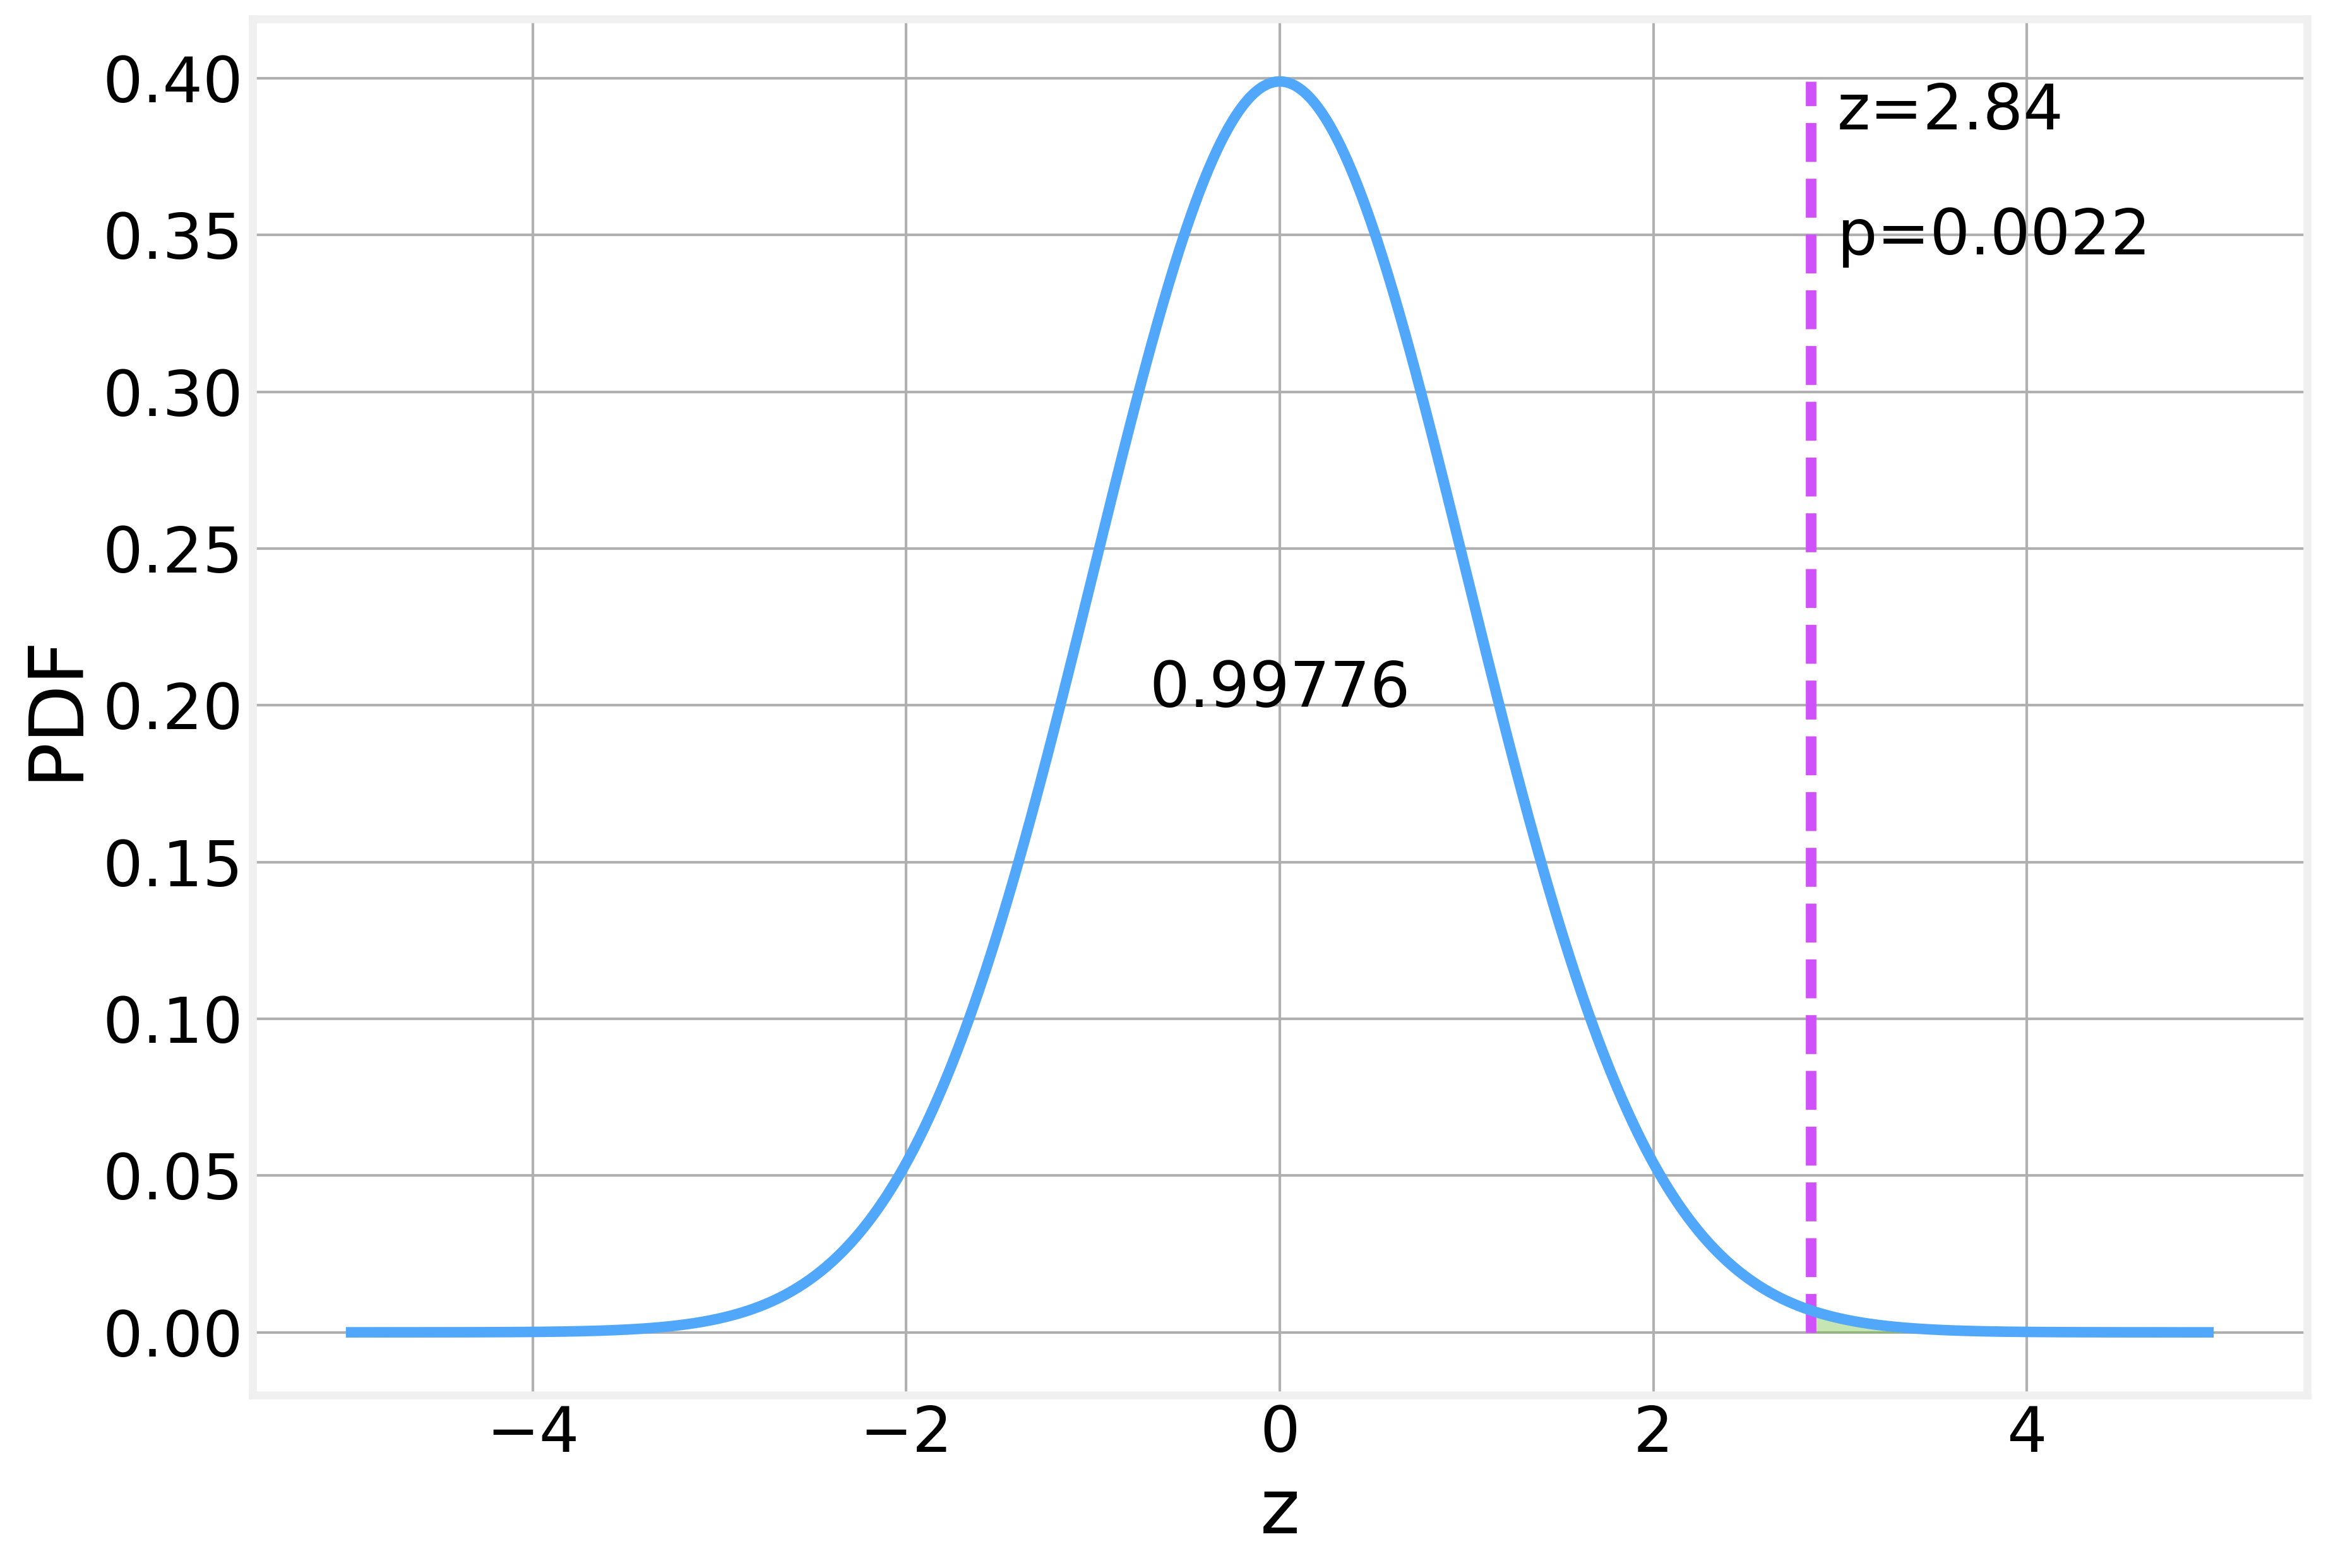

In [29]:
plot_zscore(Z)

## Simpson's Paradox

### Load the iris dataset 

In [30]:
iris = pd.read_csv('data/iris.csv')

In [31]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Split the dataset across species for convenience

In [32]:
setosa = iris[['sepal_width', 'petal_width']][iris['species'] == 'setosa']
versicolor = iris[['sepal_width', 'petal_width']][iris['species'] == 'versicolor']
virginica = iris[['sepal_width', 'petal_width']][iris['species'] == 'virginica']

### Perform the fits

In [33]:
lm_setosa = LinearRegression()
lm_setosa.fit(setosa['sepal_width'].values.reshape(-1,1), setosa['petal_width'])
y_setosa = lm_setosa.predict(setosa['sepal_width'].values.reshape(-1,1))

lm_versicolor = LinearRegression()
lm_versicolor.fit(versicolor['sepal_width'].values.reshape(-1,1), versicolor['petal_width'])
y_versicolor = lm_versicolor.predict(versicolor['sepal_width'].values.reshape(-1,1))

lm_virginica = LinearRegression()
lm_virginica.fit(virginica['sepal_width'].values.reshape(-1,1), virginica['petal_width'])
y_virginica = lm_virginica.predict(virginica['sepal_width'].values.reshape(-1,1))

lm_full = LinearRegression()
lm_full.fit(iris['sepal_width'].values.reshape(-1,1), iris['petal_width'])
y_full = lm_full.predict(iris['sepal_width'].values.reshape(-1,1))

### Generate the plot

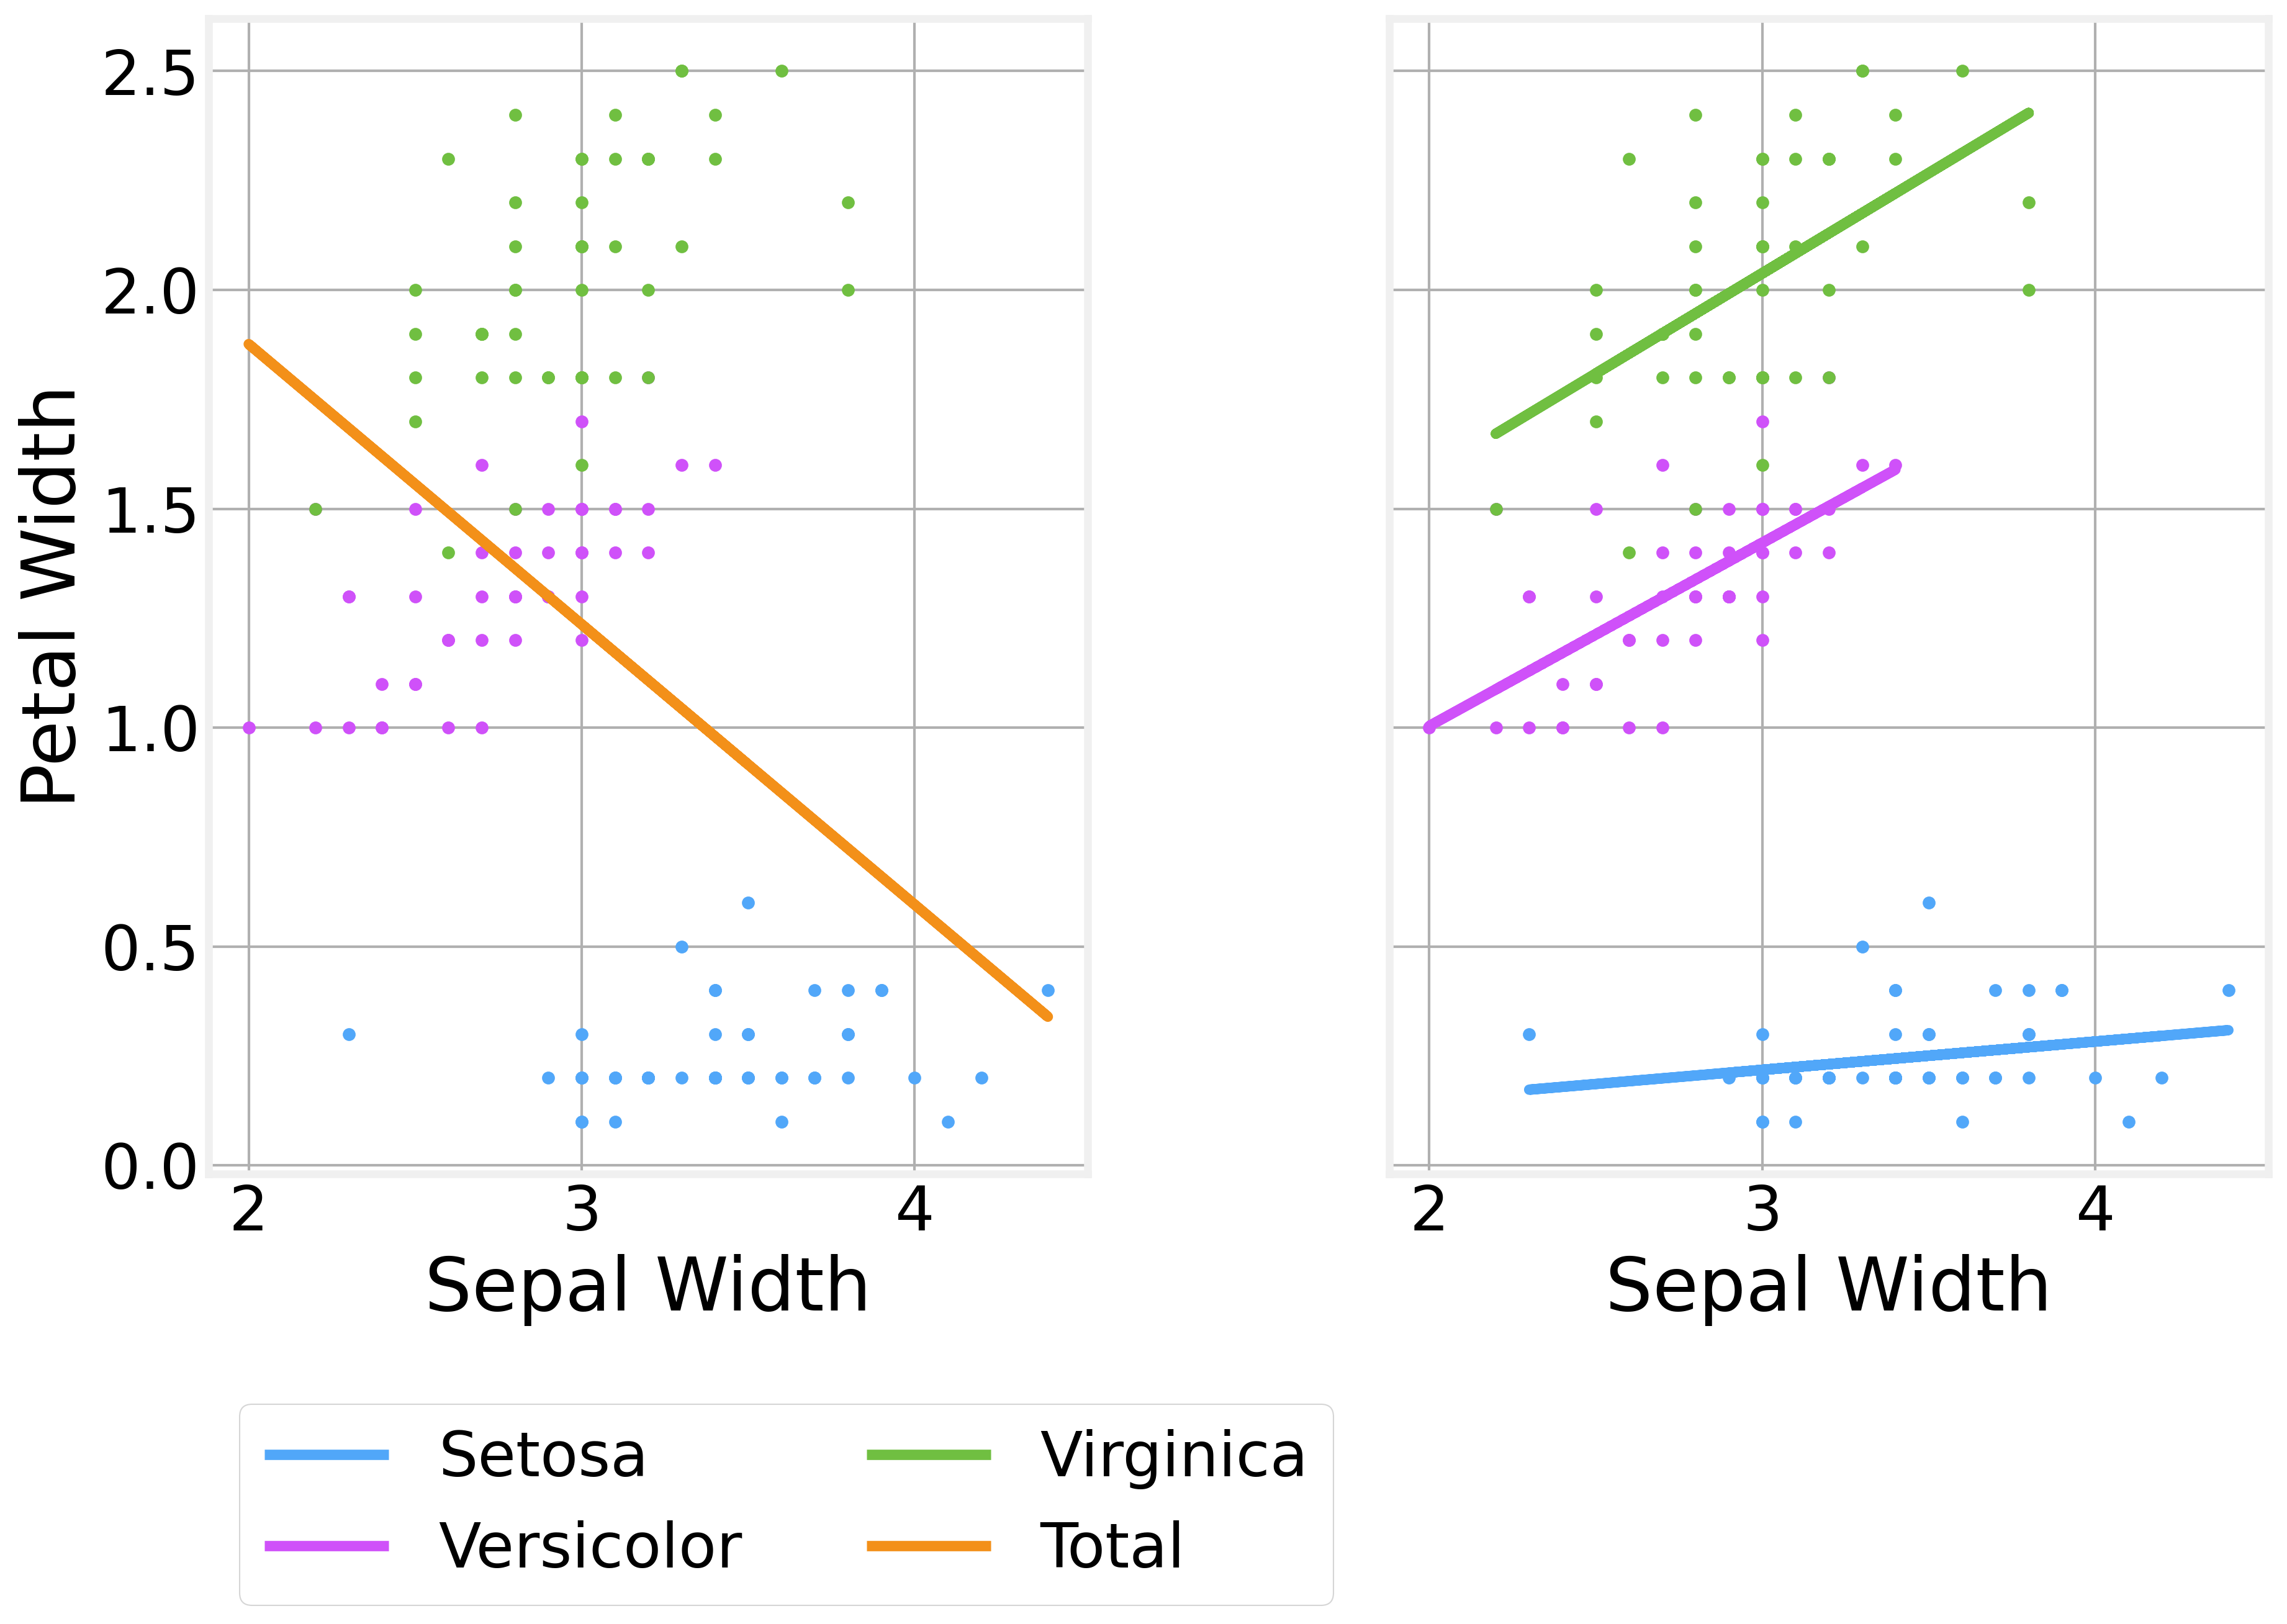

In [34]:
fig, axs = plt.subplots(ncols=2, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

setosa.plot.scatter(x='sepal_width', y='petal_width', label='setosa', ax=axs[0], c=colors[0])
versicolor.plot.scatter(x='sepal_width', y='petal_width', label='versicolor', ax=axs[0], c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', label='virginica', ax=axs[0], c=colors[2])
l4, = axs[0].plot(iris['sepal_width'].values.reshape(-1,1), y_full, '-', c=colors[3])

setosa.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[0])
versicolor.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[2])

l1, = axs[1].plot(setosa['sepal_width'].values.reshape(-1,1), y_setosa, '-', c=colors[0])
l2, = axs[1].plot(versicolor['sepal_width'].values.reshape(-1,1), y_versicolor, '-', c=colors[1])
l3, = axs[1].plot(virginica['sepal_width'].values.reshape(-1,1), y_virginica, '-', c=colors[2])

axs[0].set_xlabel('Sepal Width')
axs[1].set_xlabel('Sepal Width')
axs[0].set_ylabel('Petal Width')

fig.subplots_adjust(bottom=0.3, wspace=0.33)

axs[0].legend(handles = [l1, l2, l3, l4] , labels=['Setosa', 'Versicolor', 'Virginica', 'Total'],
             loc='lower left', bbox_to_anchor=(0, -0.4), ncol=2, fancybox=True, shadow=False)

### Removing setosa

In [35]:
reduced = iris[iris['species'] != 'setosa'].copy()

In [36]:
lm_reduced = LinearRegression()
lm_reduced.fit(reduced['sepal_width'].values.reshape(-1,1), reduced['petal_width'])
y_reduced = lm_reduced.predict(reduced['sepal_width'].values.reshape(-1,1))

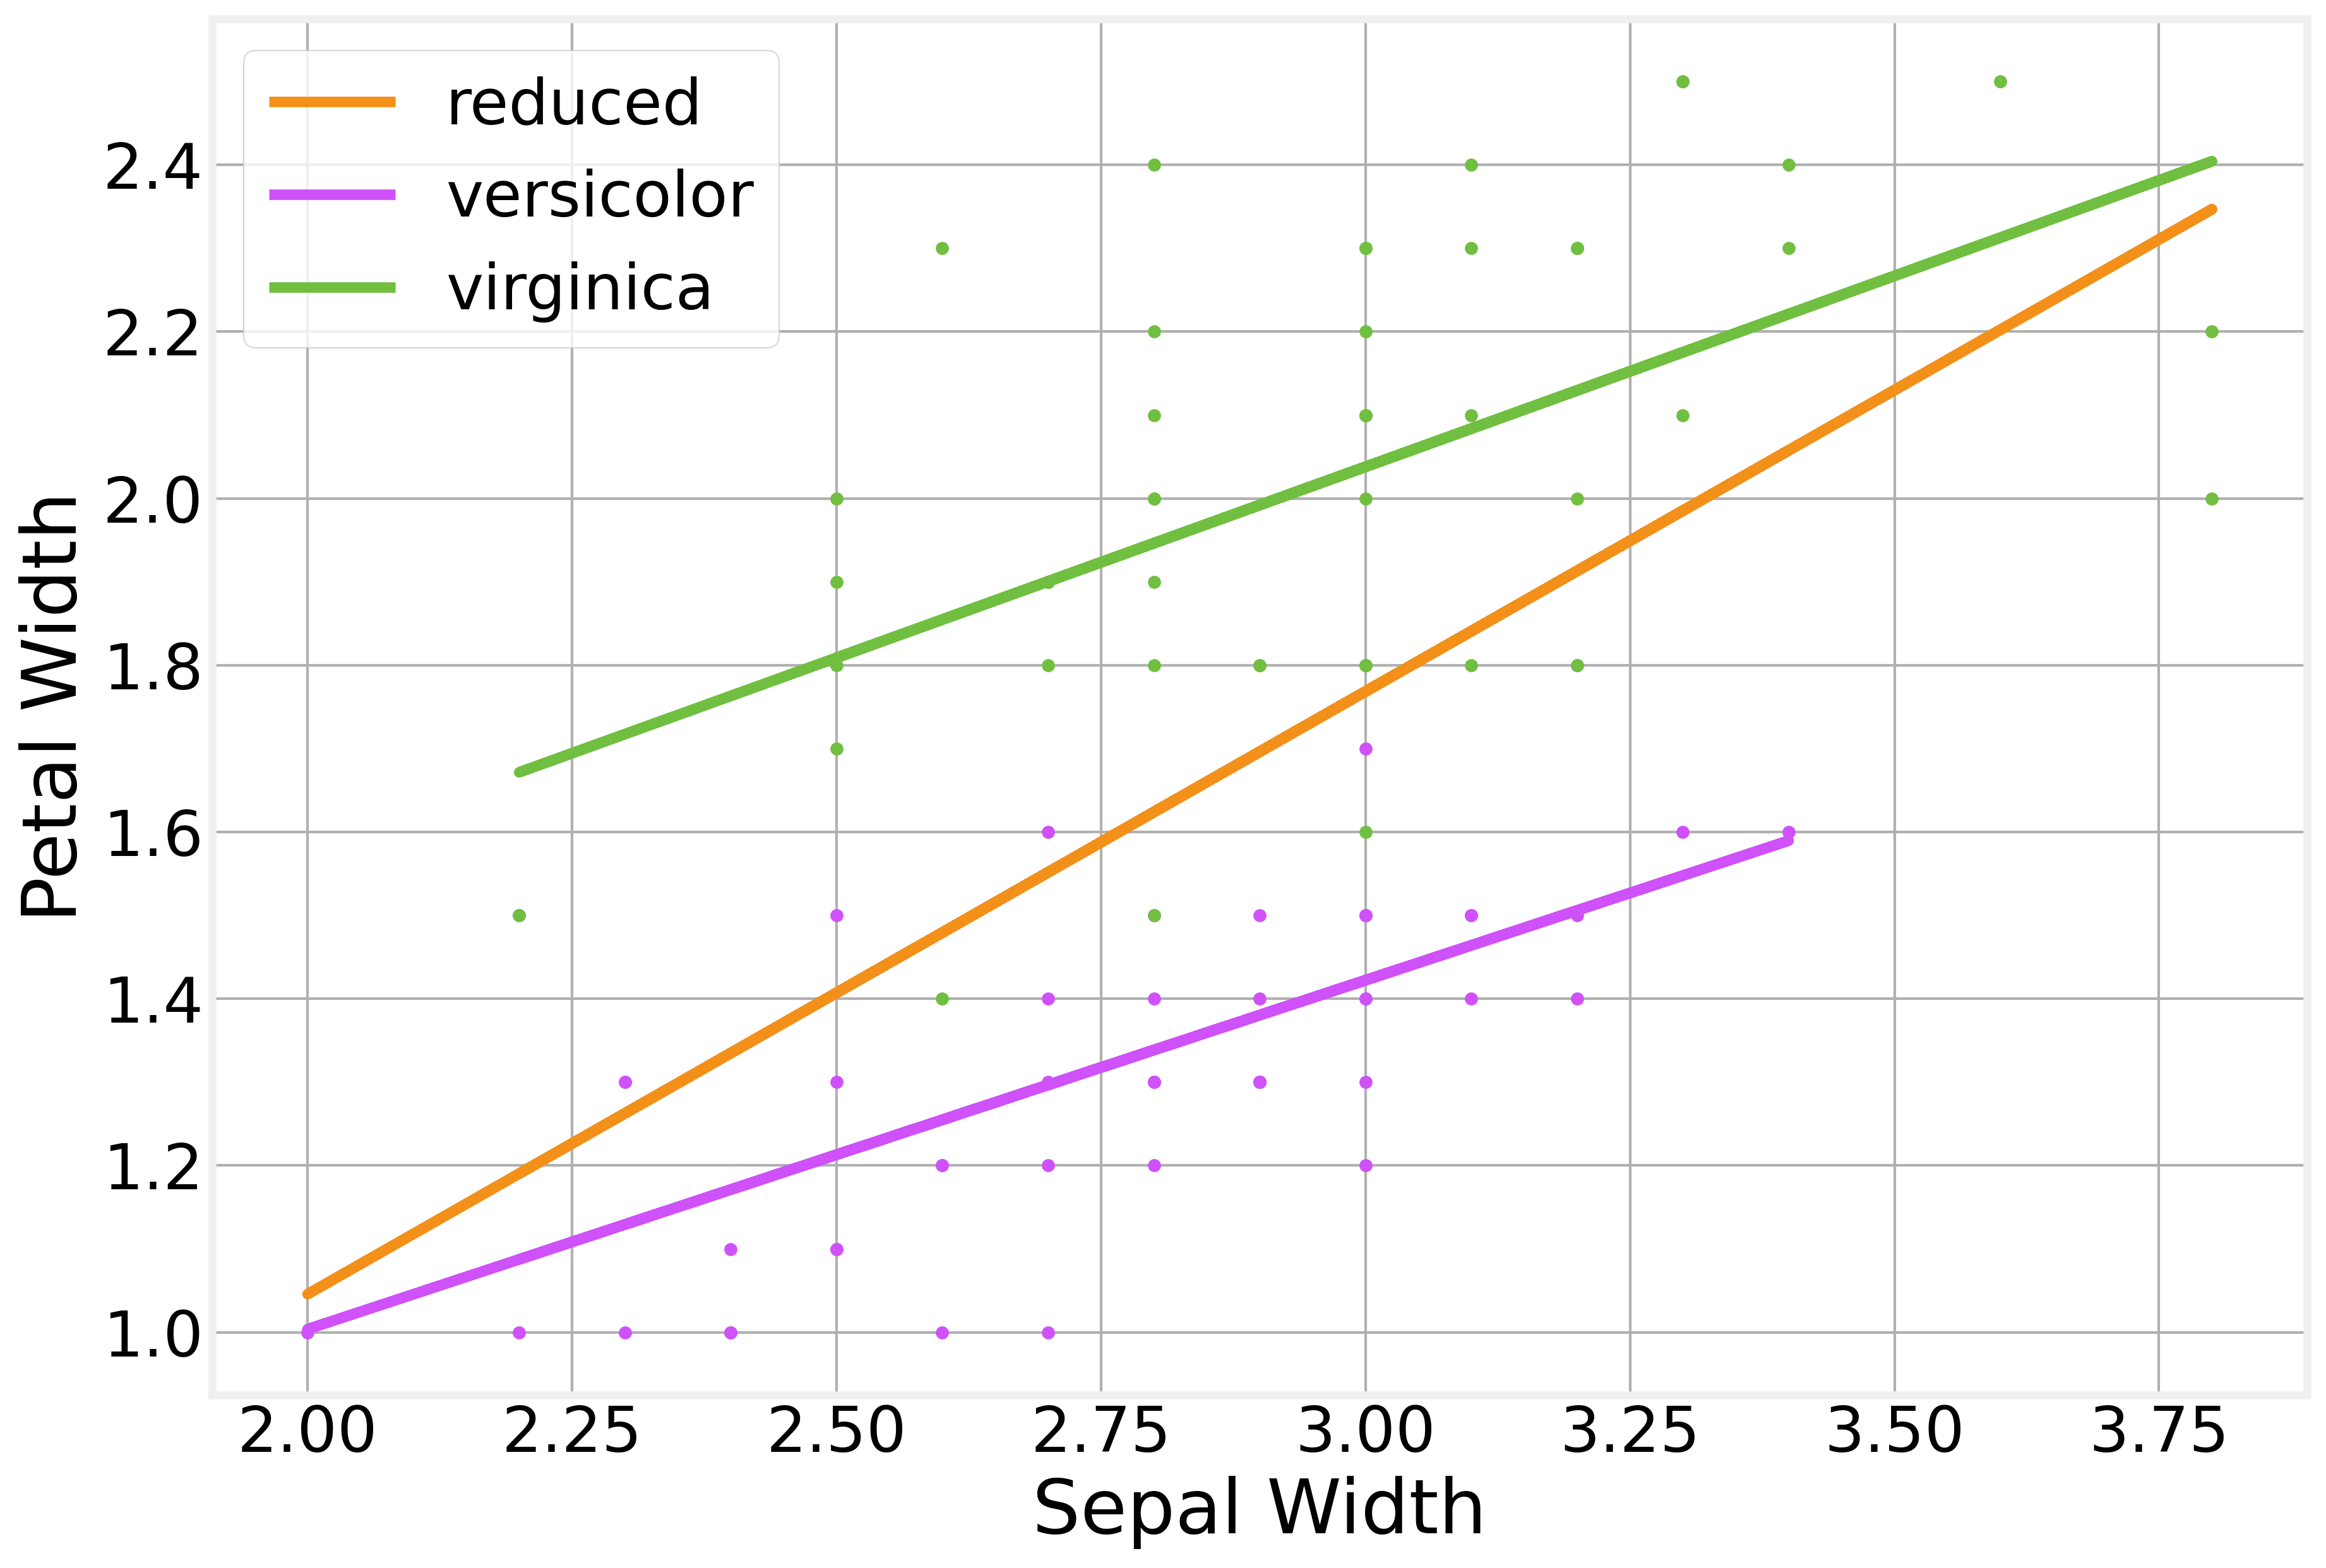

In [37]:
fig, axs = plt.subplots(ncols=1, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

versicolor.plot.scatter(x='sepal_width', y='petal_width', ax=axs, c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', ax=axs, c=colors[2])
axs.plot(reduced['sepal_width'].values.reshape(-1,1), y_reduced, '-', c=colors[3], label='reduced')
axs.plot(versicolor['sepal_width'].values.reshape(-1,1), y_versicolor, '-', c=colors[1], label='versicolor')
axs.plot(virginica['sepal_width'].values.reshape(-1,1), y_virginica, '-', c=colors[2], label='virginica')

axs.set_xlabel('Sepal Width')
axs.set_ylabel('Petal Width')
plt.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>